<a href="https://colab.research.google.com/github/wrayjaehwa/TextMining_F22/blob/main/fake_news_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import os
import zipfile
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/project-2/
%ls *.csv

Mounted at /content/drive
/content/drive/MyDrive/project-2
Fake.csv  True.csv


In [ ]:
dir_file = os.getcwd()
files_dir = os.listdir(dir_file)
csv_files = [f for f in files_dir if f.endswith('csv')]

In [ ]:
fake_df = pd.read_csv(csv_files[0])
true_df = pd.read_csv(csv_files[1])

In [ ]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
pattern = "^[A-Z/]+ \(Reuters\) - "
sum([1 for text in true_df["text"] if not re.match(pattern, text)])

5675

In [ ]:
def clean(text: str) -> str:
    return re.sub(pattern, "", text)

In [ ]:
fake_df["text"] = fake_df["text"].apply(clean)
true_df["text"] = true_df["text"].apply(clean)
true_df

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,NATO allies on Tuesday welcomed President Dona...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LexisNexis, a provider of legal, regulatory an...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,In the shadow of disused Soviet-era factories ...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,Vatican Secretary of State Cardinal Pietro Par...,worldnews,"August 22, 2017"


In [ ]:
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [ ]:
true_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [ ]:
fake_df = fake_df.drop(columns="subject")
true_df = true_df.drop(columns="subject")

In [ ]:
fake_df = fake_df.drop(columns="date")
true_df = true_df.drop(columns="date")

In [ ]:
fake_df["label"] = 0
true_df["label"] = 1

In [ ]:
df = pd.concat([fake_df[:5000], true_df[:5000]])

In [ ]:
features = df[["title", "text"]]
labels = df["label"]
features_dict = {name: np.array(value) for name, value in features.items()}

Build the preprocessing model.

It will convert string features into vectorized integer features.

Define a helper function that returns the length of the longest sequence of split strings in the column.


In [ ]:
def get_output_sequence_length(column):
    lengths = [len(x.split()) for x in column]
    return max(lengths)

In [ ]:
inputs = {}
for name, column in features.items():    
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=tf.string)
    
outputs = []
for name, input in inputs.items():
    output_sequence_length = get_output_sequence_length(features[name])
    text_vectorizer = tf.keras.layers.TextVectorization(output_sequence_length=output_sequence_length)
    text_vectorizer.adapt(features[name])
    
    x = text_vectorizer(input)
    outputs.append(x)
    
preprocessing_model = tf.keras.Model(inputs, outputs)

Now I'll add some pre-trained word embeddings.

In [ ]:
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2022-12-14 22:17:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-14 22:17:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-14 22:17:01--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [ ]:
with zipfile.ZipFile("/tmp/glove.6B.zip", "r") as zip_ref:
    zip_ref.extractall("/tmp/glove")

In [ ]:
embeddings_index = {}
f = open("/tmp/glove/glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Create a word embedding matrix for each word in the vocabulary.

In [ ]:
embedding_matrix = np.zeros((text_vectorizer.vocabulary_size(), 100))
for i, word in enumerate(text_vectorizer.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Create the embedding layer using the loaded embeddings.

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=text_vectorizer.vocabulary_size(),
    output_dim=100,
    weights=[embedding_matrix],
    input_length=100,
    trainable=False
)

Build training model

In [ ]:
preprocessed_inputs = preprocessing_model(inputs)

all_inputs = [embedding_layer(input) for input in preprocessed_inputs]

In [ ]:
flatten_layer = tf.keras.layers.Flatten()
flat_inputs = [flatten_layer(input) for input in all_inputs]

In [ ]:
x = tf.keras.layers.Concatenate()(flat_inputs)

In [ ]:
x = tf.keras.layers.Dense(units=128, activation="relu")(x)
outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

In [ ]:
training_model = tf.keras.Model(inputs, outputs)

compile training model

In [ ]:
training_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

create callback

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)]

**Train the model**

In [ ]:
history = training_model.fit(x=features_dict, y=labels, epochs=16, callbacks=callbacks, validation_split=0.25, batch_size=512)

Epoch 1/16
15/15 [==============================] - 73s 4s/step - loss: 1.7295 - acc: 0.7789 - val_loss: 0.3522 - val_acc: 0.8756
Epoch 2/16
15/15 [==============================] - 62s 4s/step - loss: 0.1120 - acc: 0.9628 - val_loss: 0.1921 - val_acc: 0.9432
Epoch 3/16
15/15 [==============================] - 68s 4s/step - loss: 0.0506 - acc: 0.9849 - val_loss: 0.1346 - val_acc: 0.9576
Epoch 4/16
15/15 [==============================] - 60s 4s/step - loss: 0.0280 - acc: 0.9944 - val_loss: 0.1015 - val_acc: 0.9736
Epoch 5/16
15/15 [==============================] - 59s 4s/step - loss: 0.0163 - acc: 0.9981 - val_loss: 0.0923 - val_acc: 0.9780
Epoch 6/16
15/15 [==============================] - 62s 4s/step - loss: 0.0107 - acc: 0.9993 - val_loss: 0.0903 - val_acc: 0.9756
Epoch 7/16
15/15 [==============================] - 59s 4s/step - loss: 0.0077 - acc: 0.9997 - val_loss: 0.0967 - val_acc: 0.9736
Epoch 8/16
15/15 [==============================] - 59s 4s/step - loss: 0.0058 - acc: 1.00

Plot model losses

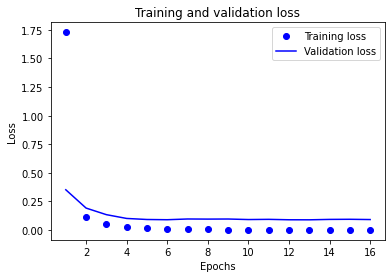

In [ ]:
history_dict = history.history
acc = history_dict["acc"]
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(acc) + 1)

plt.clf()   # Clears the figure
plt.plot(epochs, loss_values, "bo", label="Training loss")   # "bo" is for "blue dot"
plt.plot(epochs, val_loss_values, "b", label="Validation loss")   # "b" is for "solid blue line"
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Plot model accuracy

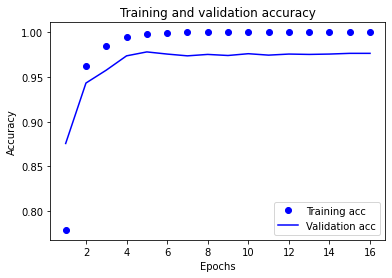

In [ ]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()